In [4]:
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [5]:
data_dir = './indoor_outdoor_dataset/'

transform = transforms.Compose([
    transforms.Resize(224),          
    transforms.CenterCrop(224),       
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_data = datasets.ImageFolder(data_dir, transform=transform)

class_indices = {class_name: [] for class_name in full_data.classes}

for idx, (path, label) in enumerate(full_data.samples):
    class_name = full_data.classes[label]
    class_indices[class_name].append((idx, path))

filtered_indices = []
for class_name, items in class_indices.items():
    sorted_items = sorted(items, key=lambda x: os.path.basename(x[1]))
    half_len = len(sorted_items) // 2
    filtered_indices.extend([idx for idx, _ in sorted_items[:half_len]])

filtered_data = torch.utils.data.Subset(full_data, filtered_indices)

train_size = int(0.8 * len(filtered_data))
val_size = int(0.1 * len(filtered_data))
test_size = len(filtered_data) - train_size - val_size

train_data, val_data, test_data = random_split(filtered_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(full_data.class_to_idx)

{'indoor': 0, 'outdoor': 1}


In [64]:
# data_dir = './indoor_outdoor_dataset/'

# train_transform = transforms.Compose([
#     transforms.Resize(256),              
#     transforms.RandomResizedCrop(224),   
#     transforms.RandomHorizontalFlip(),   
#     transforms.RandomRotation(15),       
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# full_data = datasets.ImageFolder(data_dir, transform=test_transform)

# class_indices = {class_name: [] for class_name in full_data.classes}
# for idx, (path, label) in enumerate(full_data.samples):
#     class_name = full_data.classes[label]
#     class_indices[class_name].append((idx, path))

# filtered_indices = []
# for class_name, items in class_indices.items():
#     sorted_items = sorted(items, key=lambda x: os.path.basename(x[1]))
#     half_len = len(sorted_items) // 4
#     filtered_indices.extend([idx for idx, _ in sorted_items[:half_len]])

# filtered_data = torch.utils.data.Subset(full_data, filtered_indices)

# train_size = int(0.8 * len(filtered_data))
# val_size = int(0.1 * len(filtered_data))
# test_size = len(filtered_data) - train_size - val_size

# train_data, val_data, test_data = random_split(filtered_data, [train_size, val_size, test_size])

# train_data.dataset.transform = train_transform
# val_data.dataset.transform = test_transform
# test_data.dataset.transform = test_transform

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# print(full_data.class_to_idx)


In [6]:
class BinaryClassifierBaseline(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()
        self.block1 = self.vgg_block(3, 32, 2)
        self.block2 = self.vgg_block(32, 64, 2)
        self.block3 = self.vgg_block(64, 128, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.4)
    
    def vgg_block(self, in_channels, out_channels, num_convs):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_1x1conv = use_1x1conv
        if use_1x1conv: 
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.use_1x1conv:
            residual = self.conv1x1(residual) 
        x += residual 
        return self.relu(x)

class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()
        self.block1 = ResidualBlock(3, 64, use_1x1conv=True, strides=2)
        self.block2 = ResidualBlock(64, 128, use_1x1conv=True, strides=2)
        self.block3 = ResidualBlock(128, 256, use_1x1conv=True, strides=2)
        self.block4 = ResidualBlock(256, 512, use_1x1conv=True, strides=2)
        self.block5 = ResidualBlock(512, 512, use_1x1conv=True, strides=2)
        self.block6 = ResidualBlock(512, 1024, use_1x1conv=True, strides=2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)  
        x = self.block6(x)
        
        x = self.adaptive_pool(x)  
        x = x.view(x.size(0), -1) 
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [8]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=2, use_batchnorm=True):
        super(VGGBlock, self).__init__()
        layers = []
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)

class BinaryClassifierVGG(nn.Module):
    def __init__(self):
        super(BinaryClassifierVGG, self).__init__()
        
        self.block1 = VGGBlock(3, 64, num_convs=2) 
        self.block2 = VGGBlock(64, 128, num_convs=2)
        self.block3 = VGGBlock(128, 256, num_convs=3)
        self.block4 = VGGBlock(256, 512, num_convs=3)
        self.block5 = VGGBlock(512, 512, num_convs=3)
        self.block6 = VGGBlock(512, 1024, num_convs=3) 

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.block1(x))  
        x = self.pool(self.block2(x))
        x = self.pool(self.block3(x))
        x = self.pool(self.block4(x))
        x = self.pool(self.block5(x))
        x = self.pool(self.block6(x))  

        x = self.adaptive_pool(x)  
        x = x.view(x.size(0), -1)  

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [11]:
model = BinaryClassifierCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [9]:
def load_checkpoint(filename='cnn_checkpoint.pth'):
    checkpoint = torch.load(filename)
    return checkpoint

In [13]:
checkpoint = load_checkpoint('cnn_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
best_val_acc = checkpoint['accuracy']

In [24]:
def save_checkpoint(state, filename='checkpoint_vgg.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy, (all_labels, all_predictions)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    
    writer = SummaryWriter('runs/indoor_outdoor_CNN')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        batch_time_start = time.time()
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)):
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 300 == 0:
                avg_loss = running_loss / 300
                train_acc = correct / total
                writer.add_scalar('Loss/train_batch', avg_loss, epoch * len(train_loader) + i)
                writer.add_scalar('Accuracy/train_batch', train_acc, epoch * len(train_loader) + i)
                running_loss = 0.0
                correct = 0
                total = 0

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        writer.add_scalar('Loss/train', train_loss, epoch)   
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, 'cnn_checkpoint.pth')
            
    writer.close()

In [ ]:
num_epochs = 2
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [25]:
test_loss, test_acc, labels_and_predictions = evaluate_model(model, test_loader, criterion)

In [26]:
test_acc

0.9285331514590539

# 1) Выведите кол-во обучаемых параметров сети;

In [21]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'количество обучаемых параметров: {num_params}')

количество обучаемых параметров: 24796866


# 2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.

Добавление большего количества сверточных блоков привело к большему числу параметров, большему полю восприятия,
это позволило распозновать более сложные особенности изображений, что улучшило точность.  
Глубина сети увеличилась, чтобы избежать затухание градиентов я реализовал residual connections, обучение стало более стабильным.
Был полезен Batch Normalization, который нормализует распределение выходов нейронов.

на cpu жестко некомфортно обучать :(

# 3) Посчитайте F1-score на тестовой подвыборке.

In [29]:
from sklearn.metrics import f1_score


all_labels, all_predictions = labels_and_predictions
f1_score = f1_score(all_labels, all_predictions)

print(f'{f1_score=}')

f1_score=0.9253016956056825


# 4) Выведите confusion matrix для тестовой подвыборки.

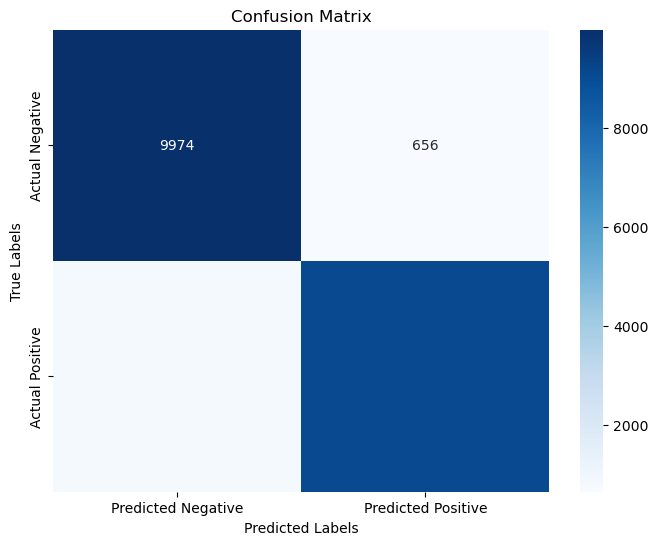

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

TP = np.sum((y_true == 1) & (y_pred == 1))
TN = np.sum((y_true == 0) & (y_pred == 0))
FP = np.sum((y_true == 0) & (y_pred == 1))
FN = np.sum((y_true == 1) & (y_pred == 0))

confusion_matrix = np.array([[TN, FP], 
                              [FN, TP]])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [63]:
confusion_matrix

array([[9974,  656],
       [ 811, 9086]])